# Context
This notebook is created to propagate and visualize the fitting results previously obtained by (e.g.) the `Fit_componentwise.ipynb` notebook or the corresponding python script.<br>
The main reasons for this are memory usage and possibly timing based arguments, if fits take hours to complete.

In [1]:
from threeML import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import astropy.io.fits as fits
import sys
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['legend.fontsize'] = 16

15:36:01 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=68799;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=871177;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=79871;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=789114;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=311826;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=612317;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=597582;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=741197;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=340699;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=478451;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=517957;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=514857;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=147132;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=792992;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=542198;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=99427;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=296090;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=617644;file:///home/yahecker/.virtualenvs/3ML/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

In [2]:
from scipy import constants as const
from scipy.optimize import fsolve
from scipy.stats import norm

These functions are also contained in `xrb_root_f.py`, so they can be imported from there. However, It is sometimes easier having them here explicitely, in case there are errors somewhere or you want to modify them locally.

In [3]:
Rs = 6.963e8 #[m]  
Ts = 5778.  
G = const.G
Ms = 1.9891e30
P = 0.32301405
K = 437.1
c = const.c
CONST = (Rs*c**2/(2*G*Ms))**0.75

def fM(K,P):
    Ms = 1.9891e30
    f = K**3 * 10**9 * P *24*3600/ (2*np.pi*const.G)/Ms
    return f

def M2(T):
    M2 = (T/5778.)**(4/2.5)
    #M2 = 0.26
    return M2

def mfunc(x, ink, K, P, T):
    f = fM(K, P)
    sinthird = np.sin(ink/180. *np.pi)**3
    return f*(1. + M2(T) / x)**2 / sinthird - x

def adistance(M_star, M_bh, P):
    '''Orbital distance given M1, M2 and P.
    Units: Solar radii.'''
    adist = (  ( (G*(M_star+M_bh)*Ms*(P*24*60*60)**2) /(4*const.pi**2) )**(1.0/3.0)  ) /Rs
    return adist

def rd_t(M_star, M_bh):
    '''Tidal disrupiton radius given M1 and M2.
    Units: orbital separations.'''
    q = M_star/M_bh
    tidalradius = 0.9 * 0.49 * np.power(q, -2/3.)/(0.6 * np.power(q, -2/3.) + np.log10(1. + np.power(q, -1/3.))) 
    return tidalradius

def R_circ(M_star, M_bh):
    '''Circularisation radius given M1 and M2.
    Units: orbital separations.'''
    q = M_star/M_bh
    return 0.0859*np.power(q, -0.426)

def M1new(ink, K, P, T):
    sol = fsolve(mfunc,
                 7*np.ones(np.size(ink)),
                 args = (ink, K, P, T)
                )
    return sol

def R_S(M1):
    return 2.*G*M1/c**2    # R_s in m

def Tinner(Tout, f_r, R_in, M1, M2, full_output=False):
    '''Calculates the accretion disc temperature at the inner radius, assuming a
    powerlaw in distance with index 0.75.
    
    Note: This is pretty meaningless for a viscous disc, but in case this result
    is significantly below 10^4 K, your disc should not be emitting any hydrogen 
    line components.'''
    
    distance = adistance(M2, M1, P) ### [R_Sun]
    physical_r_out = ( R_circ(M2, M1) + f_r * (rd_t(M2, M1) - R_circ(M2, M1)) ) * distance ### [R_Sun]
    physical_r_in = R_in * R_S(M1*Ms) / Rs ### [R_Sun]
    if not full_output:
        return Tout * np.power(physical_r_out / physical_r_in, 0.75)
    return Tout * np.power(physical_r_out / physical_r_in, 0.75), physical_r_out/distance, physical_r_in/distance

In [4]:
R_S(Ms)

2954.2750782607873

## Load samples generated during the fit using only the result file (much less memory needed, and much faster)

In [5]:
resfile = '/home/yahecker/FluxA06/Fitting_Results/A06_f_noHS_3comp.fits'

sample_dict = {}

best_dict = {}

with fits.open(resfile) as f:
    head = f[1].columns
    dat = f[1].data
    for r in range(len(dat)):
        par = dat[r][0].split('.')[-1]
        
        sample_dict[par] = dat[r][-1]
        best_dict[par] = dat[r][1]

In [ ]:
for key, value in sample_dict.items():
    print(key, best_dict[key], np.median(value))

In [ ]:
sample_dict.keys()

Sometimes, it can be useful to visualize certain parameters with a third one as the color. This can, at times, expose some clear systematics more easily than corner plots.

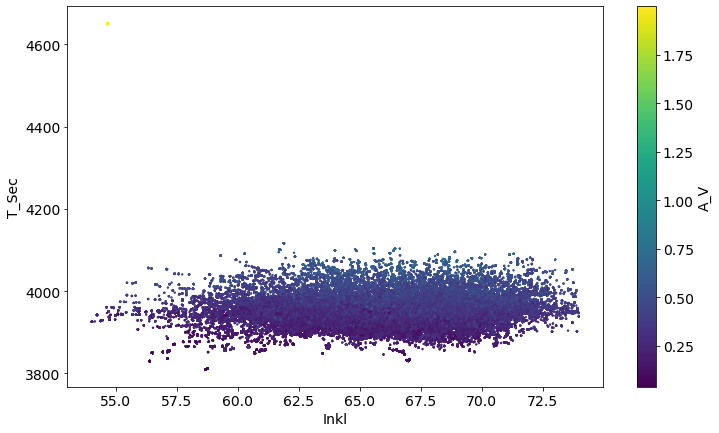

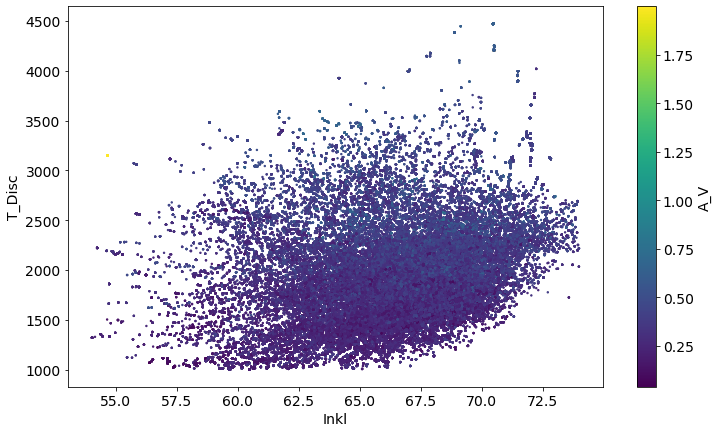

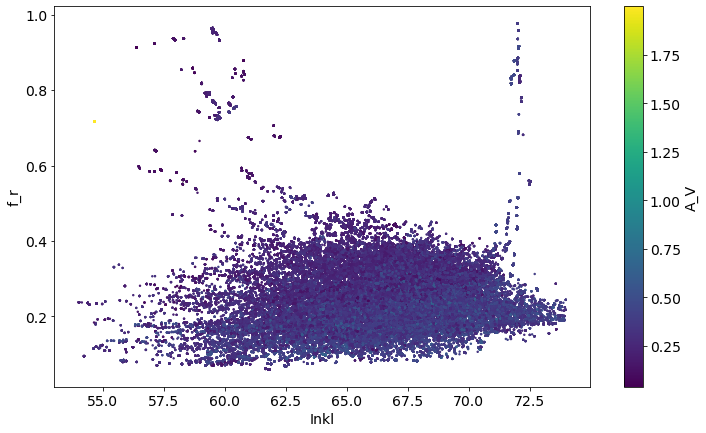

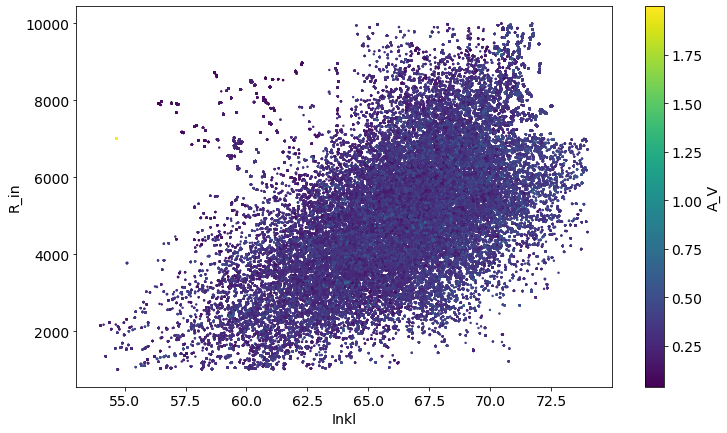

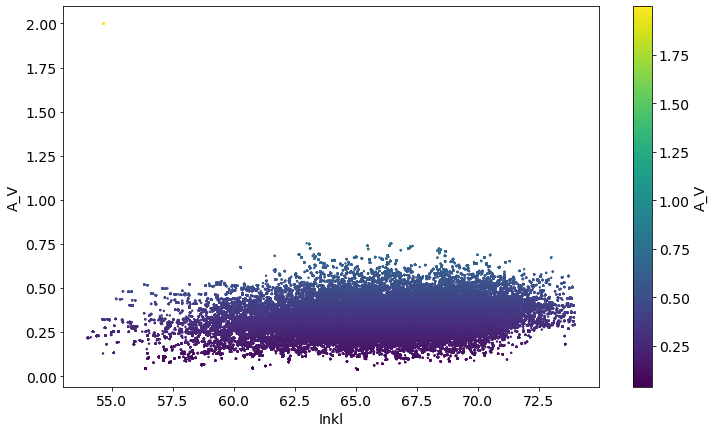

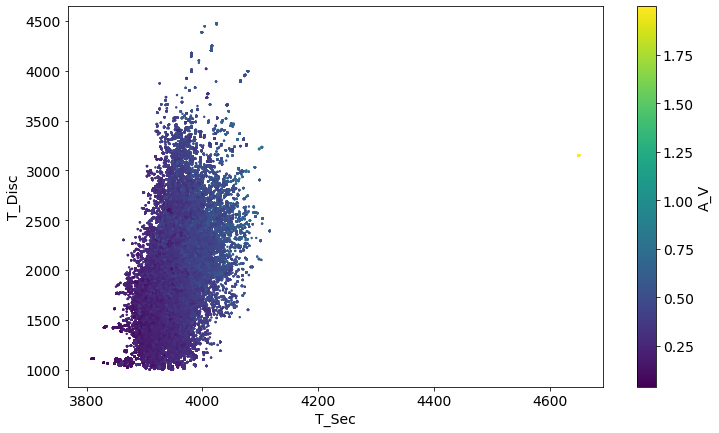

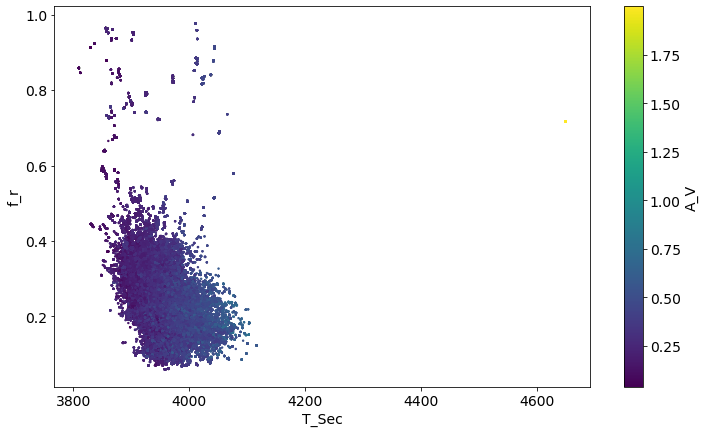

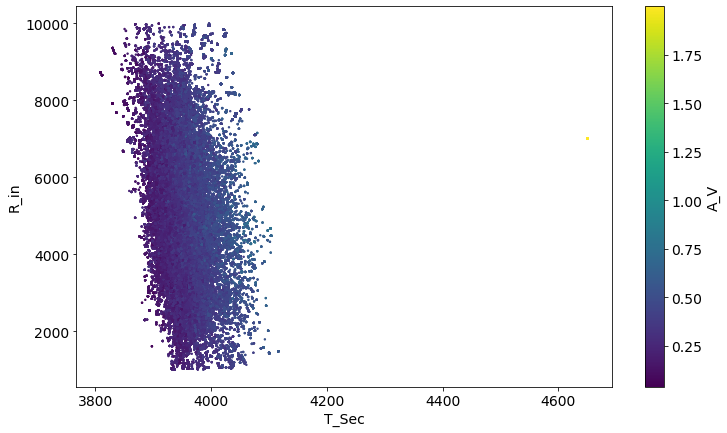

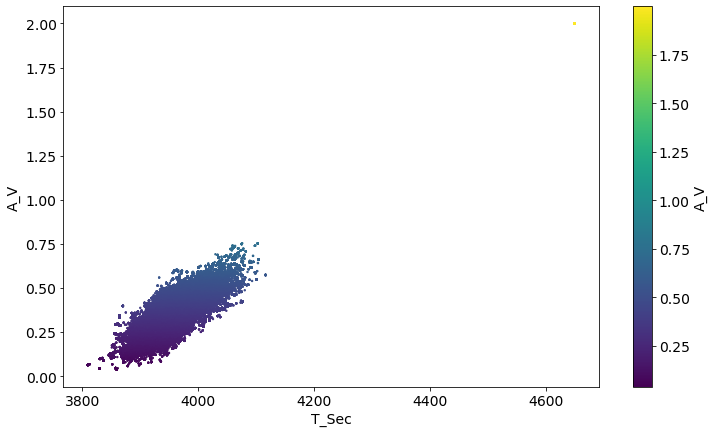

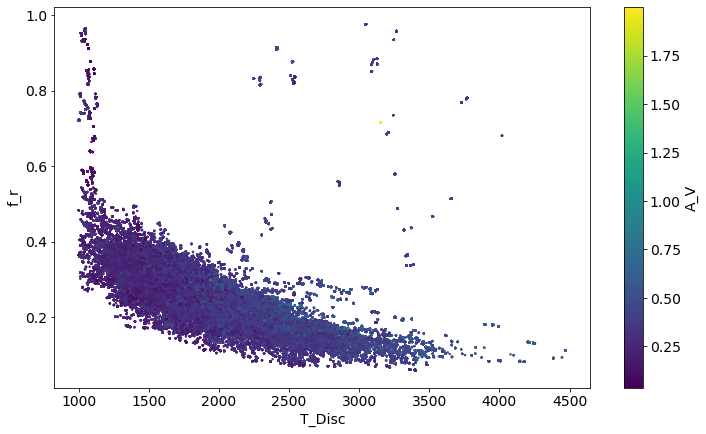

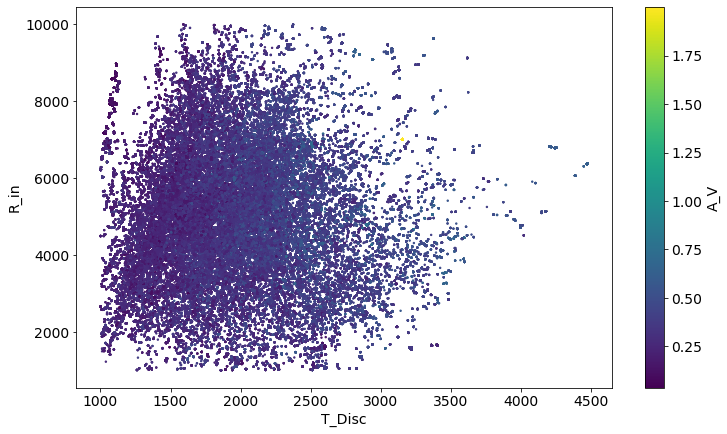

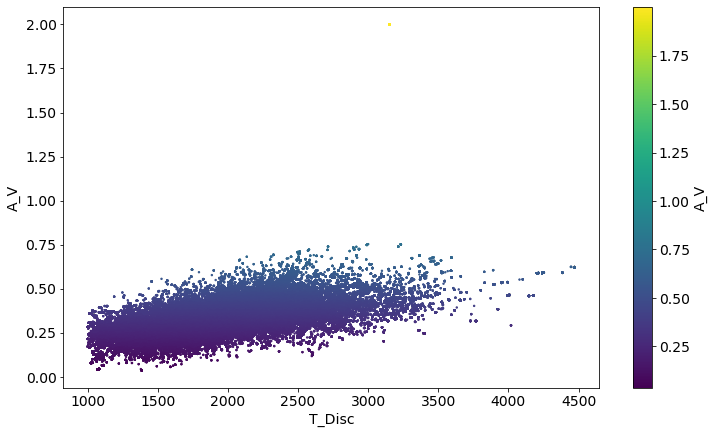

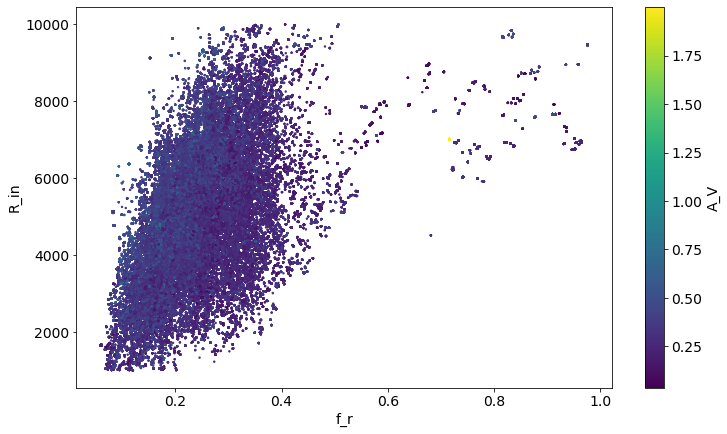

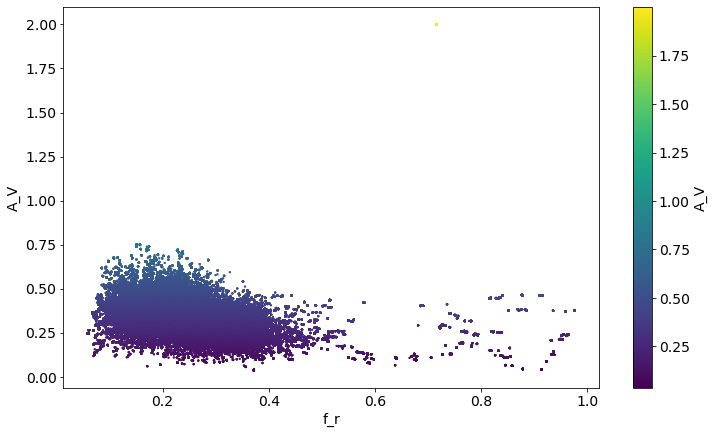

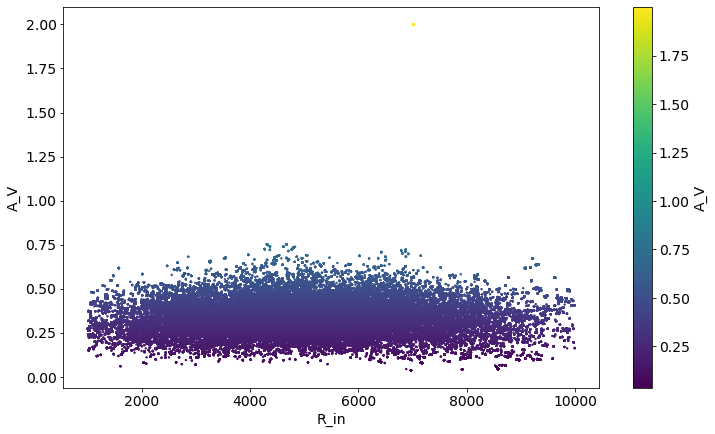

In [6]:
labels = list(sample_dict.keys())

for i, label1 in enumerate(labels):
    for j in range(i+1, len(labels)):
        plt.figure()
        x = labels[i]
        y = labels[j]

        plt.scatter(sample_dict[x], sample_dict[y], s=2 ,cmap='viridis', c=sample_dict['A_V'])
        # plt.scatter(sample_dict[x], sample_dict[y], s=2 ,cmap='viridis', c=np.arange(np.alen(sample_dict[x])))
        plt.xlabel(x)
        plt.ylabel(y)
        plt.colorbar(label='A_V')
        
        # plt.savefig(f'plots/AV_pair_plot_{label1}_{labels[j]}.png', dpi=600)
        
        # print(f'Saved {label1}-{labels[j]} combination plot...')
plt.show()

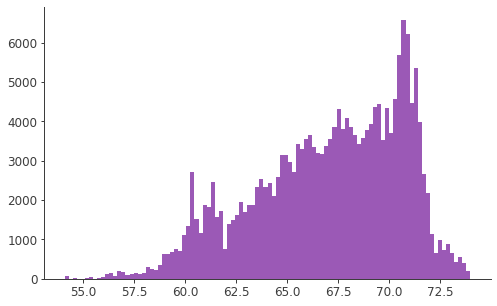

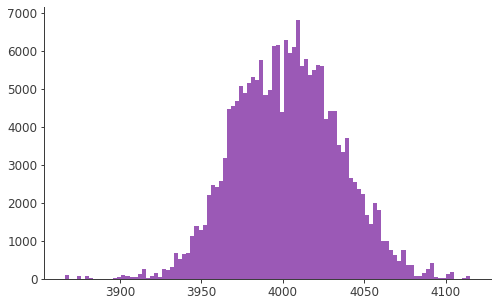

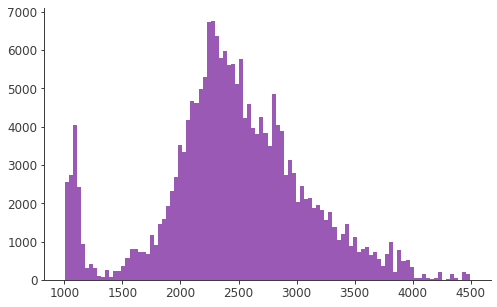

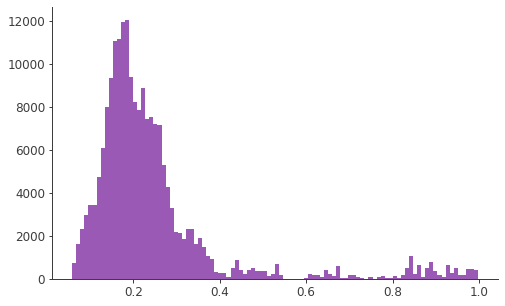

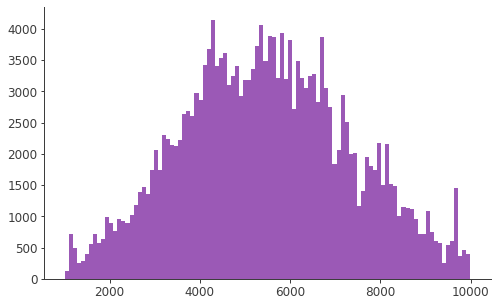

In [73]:
for key, value in sample_dict.items():
    plt.figure()
    plt.hist(value, bins=100)
    

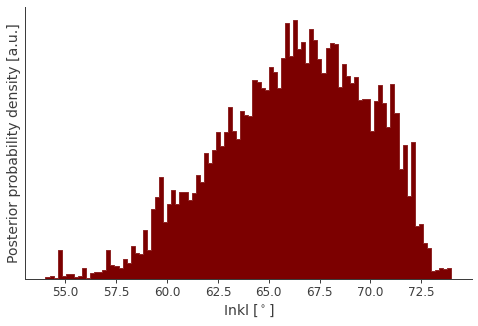

In [31]:
### Make the marginalized posterior distribution just a tad nicer to look at.
### Color codes taken from Michael Betancourt's works, because it's a gorgeous color.
plt.figure(figsize=(8, 5))
plt.hist(sample_dict['Inkl'], bins=100, density=True, color='#7C0000', ec='#8F2727', histtype='stepfilled')
plt.tick_params(left=False, labelleft=False)
plt.ylabel('Posterior probability density [a.u.]')
plt.xlabel(r'Inkl [$^\circ$]')
plt.savefig('plots/Inkl_f_noHS_3comp.pdf')

Just some object manipulation, because I am a pleb and don't know better.

In [6]:
sample_frame = pd.DataFrame(sample_dict)

In [7]:
samples = sample_frame.to_numpy()
### This single sample at high AV typically screws up the PPCs down the line, so I excluded it.
### Yes, I am naughty. No, Santa brought me no presents, and I know why now.
samples = samples[samples[:, -1] < 1.3]

## Create PPCs

In [8]:
from threeML import *

%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['legend.fontsize'] = 16

In [16]:
silence_logs()

In [17]:
def PPC_per_band(model, samples, dataset=None, n_sim=100, index_array=None):
    '''Compute posterior predictive checks for a given
    <model>, posterior samples <samples> and dataset.'''
    
    assert dataset is not None, "No datalist provided!"
    
    container = np.zeros((n_sim, np.size(dataset.x)))
    
    dataset.set_model(model)

    length = np.max(np.shape(samples))
    
    if index_array is None:
        print(f"No indizes provided. Using {n_sim} random samples that cannot be recovered!")
        index_array = np.random.default_rng().integers(0, length, n_sim)
    
    for j in range(n_sim):
        
        ### assign the model the values
        for name_ind, par_name in enumerate(list(model.free_parameters.keys())):
            # model.free_parameters[par_name].value = samples[par_name][index]
            model.free_parameters[par_name].value = samples[index_array[j], name_ind]
        
        ### simulate data
        container[j] = dataset.get_simulated_dataset().y
    
    return container

In [31]:
def Component_per_band(model, samples, band=None, phases=None, index_array=None):
    '''Compute posterior component contribution for a given
    <model>, posterior samples <samples> and orbital phases
    to be covered.'''
    
    assert band is not None, "Please provide a band for the PPC!"
    
    assert phases is not None, "No orbital phases provided!"
    
    if index_array is None:
        print('No random array of indizes provided. Using 100 randomly generated numbers instead.')
        index_array = np.random.default_rng().integers(0, np.max(np.shape(samples)), 100)
    
    container_star = np.zeros((np.size(index_array), np.size(phases)))
    container_disc = container_star.copy()
    
    for j, index in enumerate(index_array):
        ### assign the model the values
        for name_ind, par_name in enumerate(list(model.free_parameters.keys())):
            model.free_parameters[par_name].value = samples[index, name_ind]
        
        ### get the lightcurve for the specific band
        container_star[j] = model.point_sources[f'{band}_source'].spectrum.Star.shape(phases)
        container_disc[j] = model.point_sources[f'{band}_source'].spectrum.Disc.shape(phases)
    
    return container_star, container_disc

In [18]:
pa = '/home/yahecker/Obs_Data/A0620/'
data_path = pa + 'flux_%s_fit.txt'%'g_red'
gdata = XYLike.from_text_file("gdata", data_path)
gdata.assign_to_source(source_name = 'gband_source')

data_path = pa +'flux_%s_fit.txt'%'r_red'
rdata = XYLike.from_text_file("rdata", data_path)
rdata.assign_to_source(source_name = 'rband_source')

data_path = pa +'flux_%s_fit.txt'%'i_red'
idata = XYLike.from_text_file("idata", data_path)
idata.assign_to_source(source_name = 'iband_source')

data_path = pa +'flux_%s_fit.txt'%'z_red'
zdata = XYLike.from_text_file("zdata", data_path)
zdata.assign_to_source(source_name = 'zband_source')

data_path = pa +'flux_%s_fit.txt'%'J_red'
Jdata = XYLike.from_text_file("Jdata", data_path)
Jdata.assign_to_source(source_name = 'Jband_source')

data_path = pa +'flux_%s_fit.txt'%'H_red'
Hdata = XYLike.from_text_file("Hdata", data_path)
Hdata.assign_to_source(source_name = 'Hband_source')

data_path = pa +'flux_%s_fit.txt'%'K_red'
Kdata = XYLike.from_text_file("Kdata", data_path)
Kdata.assign_to_source(source_name = 'Kband_source')

data = DataList(gdata, rdata, idata, zdata, Jdata, Hdata, Kdata)

In [19]:
def ModeltoPointSource(band):
    star = TemplateModel('A06_f_noHS_star_%s'%band, log_interp = False)
    star.K.fix = False
    star.scale.fix = True
    
    disc = TemplateModel('A06_f_noHS_disc_%s'%band, log_interp = False)
    disc.K.fix = False
    disc.scale.fix = True
    
    print(f'Loaded {band} model.')
    
    return PointSource('%s_source'%band, 0, 0, components=[SpectralComponent('Star', star), SpectralComponent('Disc', disc)])


filter_list = ['gband', 'rband', 'iband', 'zband', 'Jband', 'Hband', 'Kband']
point_source_list = ['ps_g', 'ps_r', 'ps_i', 'ps_z', 'ps_J', 'ps_H', 'ps_K']
PointSdict = {}
for h in range(len(filter_list)):
    PointSdict[point_source_list[h]] = ModeltoPointSource(filter_list[h])

my_model = Model(PointSdict['ps_g'], PointSdict['ps_r'],
                 PointSdict['ps_i'], PointSdict['ps_z'],
                 PointSdict['ps_J'], PointSdict['ps_H'], PointSdict['ps_K'])

Loaded gband model.
Loaded rband model.
Loaded iband model.
Loaded zband model.
Loaded Jband model.
Loaded Hband model.
Loaded Kband model.


In [20]:
parameter_Extinction = Parameter(name='A_V',
                                 value=0.5,
                                 min_value=0,
                                 max_value=5,
                                 free=True,
                                 # free=False,
                                 unit='',
                                 delta=0.05)

my_model.add_external_parameter(parameter_Extinction)

my_model.A_V = 0.5

In [21]:
class FilterbandExtinctionFunction(Function1D, metaclass=FunctionMeta):
    r"""
    description :
        A function for calculating the extinction over a band with a pivot band
    latex : $ F_\lambda = K \cdot 10^{-0.4 \cdot k_{band} \cdot A_V} $
    parameters :
        K :
            desc : Normalization (differential flux without extinction)
            initial value : 1.0
            is_normalization : True
            fix : True
            min : 1e-30
            max : 1e3
            delta : 0.1
        k_band :
            desc : band dependent ratio of extinction in this band relative to Johnson V band ( $ A_\lambda/A_V $ )
            initial value : 1.0
            fix : yes
            min : -2
            max : 5
    """
    
    def _set_units(self, x_unit, y_unit):
        # The extinction constants are all dimensionless
        self.k_band.unit = u.dimensionless_unscaled

        # The normalization has the same units as the flux

        self.K.unit = y_unit


    def evaluate(self, x, K, k_band):

        return K * np.power(10, -0.4 * k_band * x)

In [22]:
extinction_factors = {'g':1.282,
                      'r':0.897,
                      'i':0.641,
                      'z':0.513,
                      'J':0.385,
                      'H':0.256,
                      'K':0.128
                     }

In [23]:
my_model.link(my_model.gband_source.spectrum.Star.A06_f_noHS_star_gband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['g'] - extinction_factors['g']))
my_model.link(my_model.rband_source.spectrum.Star.A06_f_noHS_star_rband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['r'] - extinction_factors['g']))
my_model.link(my_model.iband_source.spectrum.Star.A06_f_noHS_star_iband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['i'] - extinction_factors['g']))
my_model.link(my_model.zband_source.spectrum.Star.A06_f_noHS_star_zband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['z'] - extinction_factors['g']))
my_model.link(my_model.Jband_source.spectrum.Star.A06_f_noHS_star_Jband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['J'] - extinction_factors['g']))
my_model.link(my_model.Hband_source.spectrum.Star.A06_f_noHS_star_Hband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['H'] - extinction_factors['g']))
my_model.link(my_model.Kband_source.spectrum.Star.A06_f_noHS_star_Kband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['K'] - extinction_factors['g']))

my_model.link(my_model.gband_source.spectrum.Disc.A06_f_noHS_disc_gband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['g'] - extinction_factors['g']))
my_model.link(my_model.rband_source.spectrum.Disc.A06_f_noHS_disc_rband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['r'] - extinction_factors['g']))
my_model.link(my_model.iband_source.spectrum.Disc.A06_f_noHS_disc_iband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['i'] - extinction_factors['g']))
my_model.link(my_model.zband_source.spectrum.Disc.A06_f_noHS_disc_zband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['z'] - extinction_factors['g']))
my_model.link(my_model.Jband_source.spectrum.Disc.A06_f_noHS_disc_Jband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['J'] - extinction_factors['g']))
my_model.link(my_model.Hband_source.spectrum.Disc.A06_f_noHS_disc_Hband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['H'] - extinction_factors['g']))
my_model.link(my_model.Kband_source.spectrum.Disc.A06_f_noHS_disc_Kband.K, my_model.A_V, FilterbandExtinctionFunction(k_band=extinction_factors['K'] - extinction_factors['g']))

In [24]:
allInklParams =[my_model.rband_source.spectrum.Star.A06_f_noHS_star_rband.Inkl,
                my_model.iband_source.spectrum.Star.A06_f_noHS_star_iband.Inkl,
                my_model.zband_source.spectrum.Star.A06_f_noHS_star_zband.Inkl,
                my_model.Jband_source.spectrum.Star.A06_f_noHS_star_Jband.Inkl,
                my_model.Hband_source.spectrum.Star.A06_f_noHS_star_Hband.Inkl,
                my_model.Kband_source.spectrum.Star.A06_f_noHS_star_Kband.Inkl,
                my_model.gband_source.spectrum.Disc.A06_f_noHS_disc_gband.Inkl,
                my_model.rband_source.spectrum.Disc.A06_f_noHS_disc_rband.Inkl,
                my_model.iband_source.spectrum.Disc.A06_f_noHS_disc_iband.Inkl,
                my_model.zband_source.spectrum.Disc.A06_f_noHS_disc_zband.Inkl,
                my_model.Jband_source.spectrum.Disc.A06_f_noHS_disc_Jband.Inkl,
                my_model.Hband_source.spectrum.Disc.A06_f_noHS_disc_Hband.Inkl,
                my_model.Kband_source.spectrum.Disc.A06_f_noHS_disc_Kband.Inkl]

allT_SecParams = [my_model.rband_source.spectrum.Star.A06_f_noHS_star_rband.T_Sec,
                  my_model.iband_source.spectrum.Star.A06_f_noHS_star_iband.T_Sec,
                  my_model.zband_source.spectrum.Star.A06_f_noHS_star_zband.T_Sec,
                  my_model.Jband_source.spectrum.Star.A06_f_noHS_star_Jband.T_Sec,
                  my_model.Hband_source.spectrum.Star.A06_f_noHS_star_Hband.T_Sec,
                  my_model.Kband_source.spectrum.Star.A06_f_noHS_star_Kband.T_Sec,
                  my_model.gband_source.spectrum.Disc.A06_f_noHS_disc_gband.T_Sec,
                  my_model.rband_source.spectrum.Disc.A06_f_noHS_disc_rband.T_Sec,
                  my_model.iband_source.spectrum.Disc.A06_f_noHS_disc_iband.T_Sec,
                  my_model.zband_source.spectrum.Disc.A06_f_noHS_disc_zband.T_Sec,
                  my_model.Jband_source.spectrum.Disc.A06_f_noHS_disc_Jband.T_Sec,
                  my_model.Hband_source.spectrum.Disc.A06_f_noHS_disc_Hband.T_Sec,
                  my_model.Kband_source.spectrum.Disc.A06_f_noHS_disc_Kband.T_Sec]

allT_DiscParams = [my_model.rband_source.spectrum.Star.A06_f_noHS_star_rband.T_Disc,
                   my_model.iband_source.spectrum.Star.A06_f_noHS_star_iband.T_Disc,
                   my_model.zband_source.spectrum.Star.A06_f_noHS_star_zband.T_Disc,
                   my_model.Jband_source.spectrum.Star.A06_f_noHS_star_Jband.T_Disc,
                   my_model.Hband_source.spectrum.Star.A06_f_noHS_star_Hband.T_Disc,
                   my_model.Kband_source.spectrum.Star.A06_f_noHS_star_Kband.T_Disc,
                   my_model.gband_source.spectrum.Star.A06_f_noHS_star_gband.T_Disc,
                   my_model.rband_source.spectrum.Disc.A06_f_noHS_disc_rband.T_Disc,
                   my_model.iband_source.spectrum.Disc.A06_f_noHS_disc_iband.T_Disc,
                   my_model.zband_source.spectrum.Disc.A06_f_noHS_disc_zband.T_Disc,
                   my_model.Jband_source.spectrum.Disc.A06_f_noHS_disc_Jband.T_Disc,
                   my_model.Hband_source.spectrum.Disc.A06_f_noHS_disc_Hband.T_Disc,
                   my_model.Kband_source.spectrum.Disc.A06_f_noHS_disc_Kband.T_Disc]

allf_rParams = [my_model.rband_source.spectrum.Star.A06_f_noHS_star_rband.f_r,
                my_model.iband_source.spectrum.Star.A06_f_noHS_star_iband.f_r,
                my_model.zband_source.spectrum.Star.A06_f_noHS_star_zband.f_r,
                my_model.Jband_source.spectrum.Star.A06_f_noHS_star_Jband.f_r,
                my_model.Hband_source.spectrum.Star.A06_f_noHS_star_Hband.f_r,
                my_model.Kband_source.spectrum.Star.A06_f_noHS_star_Kband.f_r,
                my_model.gband_source.spectrum.Star.A06_f_noHS_star_gband.f_r,
                my_model.rband_source.spectrum.Disc.A06_f_noHS_disc_rband.f_r,
                my_model.iband_source.spectrum.Disc.A06_f_noHS_disc_iband.f_r,
                my_model.zband_source.spectrum.Disc.A06_f_noHS_disc_zband.f_r,
                my_model.Jband_source.spectrum.Disc.A06_f_noHS_disc_Jband.f_r,
                my_model.Hband_source.spectrum.Disc.A06_f_noHS_disc_Hband.f_r,
                my_model.Kband_source.spectrum.Disc.A06_f_noHS_disc_Kband.f_r]

allRinnerParams = [my_model.rband_source.spectrum.Star.A06_f_noHS_star_rband.R_in,
                   my_model.iband_source.spectrum.Star.A06_f_noHS_star_iband.R_in,
                   my_model.zband_source.spectrum.Star.A06_f_noHS_star_zband.R_in,
                   my_model.Jband_source.spectrum.Star.A06_f_noHS_star_Jband.R_in,
                   my_model.Hband_source.spectrum.Star.A06_f_noHS_star_Hband.R_in,
                   my_model.Kband_source.spectrum.Star.A06_f_noHS_star_Kband.R_in,
                   my_model.gband_source.spectrum.Star.A06_f_noHS_star_gband.R_in,
                   my_model.rband_source.spectrum.Disc.A06_f_noHS_disc_rband.R_in,
                   my_model.iband_source.spectrum.Disc.A06_f_noHS_disc_iband.R_in,
                   my_model.zband_source.spectrum.Disc.A06_f_noHS_disc_zband.R_in,
                   my_model.Jband_source.spectrum.Disc.A06_f_noHS_disc_Jband.R_in,
                   my_model.Hband_source.spectrum.Disc.A06_f_noHS_disc_Hband.R_in,
                   my_model.Kband_source.spectrum.Disc.A06_f_noHS_disc_Kband.R_in]


my_model.link(allInklParams, my_model.gband_source.spectrum.Star.A06_f_noHS_star_gband.Inkl)
my_model.link(allT_SecParams, my_model.gband_source.spectrum.Star.A06_f_noHS_star_gband.T_Sec)
my_model.link(allT_DiscParams, my_model.gband_source.spectrum.Disc.A06_f_noHS_disc_gband.T_Disc)
my_model.link(allRinnerParams, my_model.gband_source.spectrum.Disc.A06_f_noHS_disc_gband.R_in)
my_model.link(allf_rParams, my_model.gband_source.spectrum.Disc.A06_f_noHS_disc_gband.f_r)

In [25]:
def Set_Model_Parameters(model, parameters):
    for name_ind, (par_name, par_val) in enumerate(model.free_parameters.items()):
        # print('\r',par_name)
        my_model.free_parameters[par_name].value = parameters[name_ind]

In [26]:
def FluxToMag(flux, lambdaeff):
    return -2.5*np.log10(flux)-2.402-5.0*np.log10(lambdaeff)

In [29]:
def PPC_Creator(model, in_samples, data, index_array=None, identifier='', give_ratios=True):
    
    assert identifier=='' or identifier=='low' or identifier=='high', 'This is a ver nieche function at the moment.\nPlease use either an empty string, "low" or "high" as the identifier.\nThanks'
    
    lColor=['royalblue', 'limegreen', 'goldenrod', 'tomato', 'purple', 'orange', 'grey']
        
    Lambda = np.array([4586, 6220, 7641, 8989, 12398, 16468, 21706], dtype=np.float64)
    dLambda = np.array([746, 847, 501, 637, 1183, 1351, 1516], dtype=np.float64)
    
    plt.figure()
    
    phases = np.arange(0., 1.01, 0.01)
    
    ppc_points = 1000
    
    if index_array is None:
        index_arr = np.random.default_rng().integers(0, np.max(np.shape(in_samples)), size=ppc_points)
        
    # medians = np.median(in_samples, axis=0)
    
### Note: The 'best fit' as in highest posterior density point in parameter space is not necessarily a 
### suitable indicator as to the "goodness" of the fit, since it can depend on the prior choice. You are
### Of course free to plot this solution, but it is most likely meaningless.

#     medians = list(best_dict.values())
    
#     Set_Model_Parameters(my_model, medians)
    
#     ### plot the best fit model for reference
#     LC_g = my_model.gband_source.spectrum.Star.shape(phases) + my_model.gband_source.spectrum.Disc.shape(phases)
#     LC_r = my_model.rband_source.spectrum.Star.shape(phases) + my_model.rband_source.spectrum.Disc.shape(phases)
#     LC_i = my_model.iband_source.spectrum.Star.shape(phases) + my_model.iband_source.spectrum.Disc.shape(phases)
#     LC_z = my_model.zband_source.spectrum.Star.shape(phases) + my_model.zband_source.spectrum.Disc.shape(phases)
#     LC_J = my_model.Jband_source.spectrum.Star.shape(phases) + my_model.Jband_source.spectrum.Disc.shape(phases)
#     LC_H = my_model.Hband_source.spectrum.Star.shape(phases) + my_model.Hband_source.spectrum.Disc.shape(phases)
#     LC_K = my_model.Kband_source.spectrum.Star.shape(phases) + my_model.Kband_source.spectrum.Disc.shape(phases)
    
    
#     plt.plot(phases, FluxToMag(LC_g, Lambda[0]), color=lColor[0], alpha=0.7)
#     plt.plot(phases, FluxToMag(LC_r, Lambda[1]), color=lColor[1], alpha=0.7)
#     plt.plot(phases, FluxToMag(LC_i, Lambda[2]), color=lColor[2], alpha=0.7)
#     plt.plot(phases, FluxToMag(LC_z, Lambda[3]), color=lColor[3], alpha=0.7)
#     plt.plot(phases, FluxToMag(LC_J, Lambda[4]), color=lColor[4], alpha=0.7)
#     plt.plot(phases, FluxToMag(LC_H, Lambda[5]), color=lColor[5], alpha=0.7)
#     plt.plot(phases, FluxToMag(LC_K, Lambda[6]), color=lColor[6], alpha=0.7)
    
#     for i, dataset in enumerate(data.values()):
#         plt.errorbar(dataset.x, FluxToMag(dataset.y, Lambda[i]), 2.5/np.log(10) * dataset.yerr / dataset.y, None, '+', ms=7, color='white')
#         plt.errorbar(dataset.x, FluxToMag(dataset.y, Lambda[i]), 2.5/np.log(10) * dataset.yerr / dataset.y, None, '+', ms=6.5, color=lColor[i], label=list(data.keys())[i], alpha=0.8)
    
#     # plt.gca().invert_yaxis()
#     plt.xlabel('Orbital Phase')
#     plt.ylabel(r'Brightness of the system  [$\mathrm{mag_{AB}}$]')
#     # plt.ylabel(r'Brightness of the system [$\mathrm{erg/cm^2/s/\AA}$]')
#     xmin, xmax = plt.xlim()
#     plt.xlim([xmin, xmax+0.15])
#     #_, ymax = plt.ylim()
#     #plt.ylim([0, ymax])
#     plt.gca().invert_yaxis()
#     plt.legend()
#     plt.title(f'Parameter medians fit for A0620 (no hotspot, {identifier} A_V)', fontsize=14)
    
#     plt.tight_layout()
    
#     # plt.savefig(f'plots/A06_{identifier}AV_f_noHS_3comp_bestfit.pdf', format='pdf')
    
        
#     plt.figure()
    
    ### because PPC_per_band creates simulated datasets, this would otherwise spam messages
    silence_logs()
    
    g_ppc = FluxToMag(PPC_per_band(my_model, in_samples, gdata, ppc_points, index_arr), Lambda[0])
    r_ppc = FluxToMag(PPC_per_band(my_model, in_samples, rdata, ppc_points, index_arr), Lambda[1])
    i_ppc = FluxToMag(PPC_per_band(my_model, in_samples, idata, ppc_points, index_arr), Lambda[2])
    z_ppc = FluxToMag(PPC_per_band(my_model, in_samples, zdata, ppc_points, index_arr), Lambda[3])
    J_ppc = FluxToMag(PPC_per_band(my_model, in_samples, Jdata, ppc_points, index_arr), Lambda[4])
    H_ppc = FluxToMag(PPC_per_band(my_model, in_samples, Hdata, ppc_points, index_arr), Lambda[5])
    K_ppc = FluxToMag(PPC_per_band(my_model, in_samples, Kdata, ppc_points, index_arr), Lambda[6])
    
    ### but we want the logs to remain intact, so we reactivate them here
    activate_logs()
    
    # alpha = min([5./ppc_points, 1])
    alpha = 0.4
    
    lower_1, upper_1 = 0.5 - 0.683/2, 0.5 + 0.683/2
    lower_2, upper_2 = 0.5 - 0.955/2, 0.5 + 0.955/2
    lower_3, upper_3 = 0.5 - 0.997/2, 0.5 + 0.997/2
    
    axis = 0
    
    ### this is for A0620, because there is a large gap in the data at around 0.75 in the orbit. 
    ### You can simplify this freely, but this would be a neat way of implementing such a cutoff.
    border = np.where(gdata.x > 0.7)[0][0]
    borderK = np.where(Kdata.x > 0.7)[0][0]
    
    ### 1-sigma regions    
    plt.fill_between(gdata.x[:border], np.quantile(g_ppc, lower_1, axis=axis)[:border], np.quantile(g_ppc, upper_1, axis=axis)[:border] , color=lColor[0], alpha=alpha)
    plt.fill_between(rdata.x[:border], np.quantile(r_ppc, lower_1, axis=axis)[:border], np.quantile(r_ppc, upper_1, axis=axis)[:border] , color=lColor[1], alpha=alpha)
    plt.fill_between(idata.x[:border], np.quantile(i_ppc, lower_1, axis=axis)[:border], np.quantile(i_ppc, upper_1, axis=axis)[:border] , color=lColor[2], alpha=alpha)
    plt.fill_between(zdata.x[:border], np.quantile(z_ppc, lower_1, axis=axis)[:border], np.quantile(z_ppc, upper_1, axis=axis)[:border] , color=lColor[3], alpha=alpha)
    plt.fill_between(Jdata.x[:border], np.quantile(J_ppc, lower_1, axis=axis)[:border], np.quantile(J_ppc, upper_1, axis=axis)[:border] , color=lColor[4], alpha=alpha)
    plt.fill_between(Hdata.x[:border], np.quantile(H_ppc, lower_1, axis=axis)[:border], np.quantile(H_ppc, upper_1, axis=axis)[:border] , color=lColor[5], alpha=alpha)
    plt.fill_between(Kdata.x[:borderK], np.quantile(K_ppc, lower_1, axis=axis)[:borderK], np.quantile(K_ppc, upper_1, axis=axis)[:borderK] , color=lColor[6], alpha=alpha)
    
    plt.fill_between(gdata.x[border:], np.quantile(g_ppc, lower_1, axis=axis)[border:], np.quantile(g_ppc, upper_1, axis=axis)[border:] , color=lColor[0], alpha=alpha)
    plt.fill_between(rdata.x[border:], np.quantile(r_ppc, lower_1, axis=axis)[border:], np.quantile(r_ppc, upper_1, axis=axis)[border:] , color=lColor[1], alpha=alpha)
    plt.fill_between(idata.x[border:], np.quantile(i_ppc, lower_1, axis=axis)[border:], np.quantile(i_ppc, upper_1, axis=axis)[border:] , color=lColor[2], alpha=alpha)
    plt.fill_between(zdata.x[border:], np.quantile(z_ppc, lower_1, axis=axis)[border:], np.quantile(z_ppc, upper_1, axis=axis)[border:] , color=lColor[3], alpha=alpha)
    plt.fill_between(Jdata.x[border:], np.quantile(J_ppc, lower_1, axis=axis)[border:], np.quantile(J_ppc, upper_1, axis=axis)[border:] , color=lColor[4], alpha=alpha)
    plt.fill_between(Hdata.x[border:], np.quantile(H_ppc, lower_1, axis=axis)[border:], np.quantile(H_ppc, upper_1, axis=axis)[border:] , color=lColor[5], alpha=alpha)
    plt.fill_between(Kdata.x[borderK:], np.quantile(K_ppc, lower_1, axis=axis)[borderK:], np.quantile(K_ppc, upper_1, axis=axis)[borderK:] , color=lColor[6], alpha=alpha)
    
    ### 2-sigma regions
    plt.fill_between(gdata.x[:border], np.quantile(g_ppc, lower_2, axis=axis)[:border], np.quantile(g_ppc, upper_2, axis=axis)[:border] , color=lColor[0], alpha=alpha)
    plt.fill_between(rdata.x[:border], np.quantile(r_ppc, lower_2, axis=axis)[:border], np.quantile(r_ppc, upper_2, axis=axis)[:border] , color=lColor[1], alpha=alpha)
    plt.fill_between(idata.x[:border], np.quantile(i_ppc, lower_2, axis=axis)[:border], np.quantile(i_ppc, upper_2, axis=axis)[:border] , color=lColor[2], alpha=alpha)
    plt.fill_between(zdata.x[:border], np.quantile(z_ppc, lower_2, axis=axis)[:border], np.quantile(z_ppc, upper_2, axis=axis)[:border] , color=lColor[3], alpha=alpha)
    plt.fill_between(Jdata.x[:border], np.quantile(J_ppc, lower_2, axis=axis)[:border], np.quantile(J_ppc, upper_2, axis=axis)[:border] , color=lColor[4], alpha=alpha)
    plt.fill_between(Hdata.x[:border], np.quantile(H_ppc, lower_2, axis=axis)[:border], np.quantile(H_ppc, upper_2, axis=axis)[:border] , color=lColor[5], alpha=alpha)
    plt.fill_between(Kdata.x[:borderK], np.quantile(K_ppc, lower_2, axis=axis)[:borderK], np.quantile(K_ppc, upper_2, axis=axis)[:borderK] , color=lColor[6], alpha=alpha)
    
    plt.fill_between(gdata.x[border:], np.quantile(g_ppc, lower_2, axis=axis)[border:], np.quantile(g_ppc, upper_2, axis=axis)[border:] , color=lColor[0], alpha=alpha)
    plt.fill_between(rdata.x[border:], np.quantile(r_ppc, lower_2, axis=axis)[border:], np.quantile(r_ppc, upper_2, axis=axis)[border:] , color=lColor[1], alpha=alpha)
    plt.fill_between(idata.x[border:], np.quantile(i_ppc, lower_2, axis=axis)[border:], np.quantile(i_ppc, upper_2, axis=axis)[border:] , color=lColor[2], alpha=alpha)
    plt.fill_between(zdata.x[border:], np.quantile(z_ppc, lower_2, axis=axis)[border:], np.quantile(z_ppc, upper_2, axis=axis)[border:] , color=lColor[3], alpha=alpha)
    plt.fill_between(Jdata.x[border:], np.quantile(J_ppc, lower_2, axis=axis)[border:], np.quantile(J_ppc, upper_2, axis=axis)[border:] , color=lColor[4], alpha=alpha)
    plt.fill_between(Hdata.x[border:], np.quantile(H_ppc, lower_2, axis=axis)[border:], np.quantile(H_ppc, upper_2, axis=axis)[border:] , color=lColor[5], alpha=alpha)
    plt.fill_between(Kdata.x[borderK:], np.quantile(K_ppc, lower_2, axis=axis)[borderK:], np.quantile(K_ppc, upper_2, axis=axis)[borderK:] , color=lColor[6], alpha=alpha)
    
    
    # ### 3-sigma regions
    plt.fill_between(gdata.x[:border], np.quantile(g_ppc, lower_3, axis=axis)[:border], np.quantile(g_ppc, upper_3, axis=axis)[:border] , color=lColor[0], alpha=alpha)
    plt.fill_between(rdata.x[:border], np.quantile(r_ppc, lower_3, axis=axis)[:border], np.quantile(r_ppc, upper_3, axis=axis)[:border] , color=lColor[1], alpha=alpha)
    plt.fill_between(idata.x[:border], np.quantile(i_ppc, lower_3, axis=axis)[:border], np.quantile(i_ppc, upper_3, axis=axis)[:border] , color=lColor[2], alpha=alpha)
    plt.fill_between(zdata.x[:border], np.quantile(z_ppc, lower_3, axis=axis)[:border], np.quantile(z_ppc, upper_3, axis=axis)[:border] , color=lColor[3], alpha=alpha)
    plt.fill_between(Jdata.x[:border], np.quantile(J_ppc, lower_3, axis=axis)[:border], np.quantile(J_ppc, upper_3, axis=axis)[:border] , color=lColor[4], alpha=alpha)
    plt.fill_between(Hdata.x[:border], np.quantile(H_ppc, lower_3, axis=axis)[:border], np.quantile(H_ppc, upper_3, axis=axis)[:border] , color=lColor[5], alpha=alpha)
    plt.fill_between(Kdata.x[:borderK], np.quantile(K_ppc, lower_3, axis=axis)[:borderK], np.quantile(K_ppc, upper_3, axis=axis)[:borderK] , color=lColor[6], alpha=alpha)
    
    plt.fill_between(gdata.x[border:], np.quantile(g_ppc, lower_3, axis=axis)[border:], np.quantile(g_ppc, upper_3, axis=axis)[border:] , color=lColor[0], alpha=alpha)
    plt.fill_between(rdata.x[border:], np.quantile(r_ppc, lower_3, axis=axis)[border:], np.quantile(r_ppc, upper_3, axis=axis)[border:] , color=lColor[1], alpha=alpha)
    plt.fill_between(idata.x[border:], np.quantile(i_ppc, lower_3, axis=axis)[border:], np.quantile(i_ppc, upper_3, axis=axis)[border:] , color=lColor[2], alpha=alpha)
    plt.fill_between(zdata.x[border:], np.quantile(z_ppc, lower_3, axis=axis)[border:], np.quantile(z_ppc, upper_3, axis=axis)[border:] , color=lColor[3], alpha=alpha)
    plt.fill_between(Jdata.x[border:], np.quantile(J_ppc, lower_3, axis=axis)[border:], np.quantile(J_ppc, upper_3, axis=axis)[border:] , color=lColor[4], alpha=alpha)
    plt.fill_between(Hdata.x[border:], np.quantile(H_ppc, lower_3, axis=axis)[border:], np.quantile(H_ppc, upper_3, axis=axis)[border:] , color=lColor[5], alpha=alpha)
    plt.fill_between(Kdata.x[borderK:], np.quantile(K_ppc, lower_3, axis=axis)[borderK:], np.quantile(K_ppc, upper_3, axis=axis)[borderK:] , color=lColor[6], alpha=alpha)
    
    for i, dataset in enumerate(data.values()):
        plt.scatter(dataset.x, FluxToMag(dataset.y, Lambda[i]), marker='o', color='white')
    for i, dataset in enumerate(data.values()):
        plt.scatter(dataset.x, FluxToMag(dataset.y, Lambda[i]), marker='.', color=lColor[i], label=f'{list(data.keys())[i][0]} band', alpha=0.8)
    
    plt.gca().invert_yaxis()
    plt.xlabel('Orbital Phase')
    # plt.ylabel(r'Brightness of the system [$\mathrm{erg/cm^2/s/\AA}$]')
    plt.ylabel(r'Brightness of the system  [$\mathrm{mag_{AB}}$]')
    xmin, xmax = plt.xlim()
    plt.xlim([xmin, xmax+0.15])
    _, ymax = plt.ylim()
    # plt.ylim([0, ymax])
    plt.legend()
    plt.title(f'Posterior predictive checks for A0620 (from {ppc_points} simulations, no hotspot, A_V)', fontsize=14)
    
    plt.tight_layout()
    
    plt.savefig(f'plots/A06_{identifier}AV_f_noHS_3comp_data_PPC.pdf', format='pdf')
    
    plt.show()
    
    ### QQ plots
    plt.figure(figsize=(12, 7))
    
    ppc_data = [g_ppc, r_ppc, i_ppc, z_ppc, J_ppc, H_ppc, K_ppc]
    
    labels = list(extinction_factors.keys())
    
    for i, (subdata, ppc) in enumerate(zip(data.values(), ppc_data)):
        plt.subplot(3, 3, i+1)
        
        datasum = np.cumsum(FluxToMag(subdata.y, Lambda[i]))
        # ppc_sum = np.cumsum(ppc, axis=1)
        
        plt.fill_between(datasum, np.cumsum(np.quantile(ppc, lower_1, axis=axis))-datasum, np.cumsum(np.quantile(ppc, upper_1, axis=axis))-datasum, color=lColor[i], alpha=0.3)
        plt.fill_between(datasum, np.cumsum(np.quantile(ppc, lower_2, axis=axis))-datasum, np.cumsum(np.quantile(ppc, upper_2, axis=axis))-datasum, color=lColor[i], alpha=0.3)
        plt.fill_between(datasum, np.cumsum(np.quantile(ppc, lower_3, axis=axis))-datasum, np.cumsum(np.quantile(ppc, upper_3, axis=axis))-datasum, color=lColor[i], alpha=0.3)
        
        ### 1:1 correlation expected
        plt.plot(datasum, np.zeros_like(datasum), color='#666666', linestyle='--', alpha=0.9)
        
        # plt.text(0.9, 0.1, f'{labels[i]} band')
        
        ymin, ymax = plt.ylim()
        
        plt.annotate(f'{labels[i]} band', (datasum[1], ymin + 0.9*(ymax - ymin)))
        
        if i == 3:
            plt.ylabel('Integrated brightness residuals')
        if i == 6:
            plt.xlabel('Data integrated brightness')
        
        # _, xmax = plt.xlim()
        plt.xlim([datasum[0], datasum[-1]])
    
        # plt.tight_layout()
    
    plt.savefig(f'plots/A06_{identifier}AV_f_noHS_3comp_QQ.pdf', format='pdf')
    
    
    ### If you want the component brightness predictions, give_ratios will plot the predicted brightness
    ### of each component. Note: This is not PPCs, as the GROND uncertainties would be very different 
    ### for the dimmer component emissions, which cannot be simulated.
    if give_ratios is True:
        
        ### construct the PCs
        g_star_pc, g_disc_pc = Component_per_band(my_model, in_samples, 'gband', phases, index_arr)
        r_star_pc, r_disc_pc = Component_per_band(my_model, in_samples, 'rband', phases, index_arr)
        i_star_pc, i_disc_pc = Component_per_band(my_model, in_samples, 'iband', phases, index_arr)
        z_star_pc, z_disc_pc = Component_per_band(my_model, in_samples, 'zband', phases, index_arr)
        J_star_pc, J_disc_pc = Component_per_band(my_model, in_samples, 'Jband', phases, index_arr)
        H_star_pc, H_disc_pc = Component_per_band(my_model, in_samples, 'Hband', phases, index_arr)
        K_star_pc, K_disc_pc = Component_per_band(my_model, in_samples, 'Kband', phases, index_arr)
    
        g_ratio_arr = g_disc_pc[:, 0] / (g_star_pc[:, 0] + g_disc_pc[:, 0])
        r_ratio_arr = r_disc_pc[:, 0] / (r_star_pc[:, 0] + r_disc_pc[:, 0])
        i_ratio_arr = i_disc_pc[:, 0] / (i_star_pc[:, 0] + i_disc_pc[:, 0])
        z_ratio_arr = z_disc_pc[:, 0] / (z_star_pc[:, 0] + z_disc_pc[:, 0])
        J_ratio_arr = J_disc_pc[:, 0] / (J_star_pc[:, 0] + J_disc_pc[:, 0])
        H_ratio_arr = H_disc_pc[:, 0] / (H_star_pc[:, 0] + H_disc_pc[:, 0])
        K_ratio_arr = K_disc_pc[:, 0] / (K_star_pc[:, 0] + K_disc_pc[:, 0])
        
        gm, gl, gu = np.percentile(g_ratio_arr, (50, 14, 86))
        rm, rl, ru = np.percentile(r_ratio_arr, (50, 14, 86))
        im, il, iu = np.percentile(i_ratio_arr, (50, 14, 86))
        zm, zl, zu = np.percentile(z_ratio_arr, (50, 14, 86))
        Jm, Jl, Ju = np.percentile(J_ratio_arr, (50, 14, 86))
        Hm, Hl, Hu = np.percentile(H_ratio_arr, (50, 14, 86))
        Km, Kl, Ku = np.percentile(K_ratio_arr, (50, 14, 86))
        
        print(f'Veiling factors (i.e. non-stellar / total flux):\n\tg band:\t{gm:.2f} ({gl:.2f}, {gu:.2f})\n'\
              + f'\tr band:\t{rm:.2f} ({rl:.2f}, {ru:.2f})\n'\
              + f'\ti band:\t{im:.2f} ({il:.2f}, {iu:.2f})\n'\
              + f'\tz band:\t{zm:.2f} ({zl:.2f}, {zu:.2f})\n'\
              + f'\tJ band:\t{Jm:.2f} ({Jl:.2f}, {Ju:.2f})\n'\
              + f'\tH band:\t{Hm:.2f} ({Hl:.2f}, {Hu:.2f})\n'\
              + f'\tK band:\t{Km:.2f} ({Kl:.2f}, {Ku:.2f})')
        
        fig, ax = plt.subplots()
        
        SED_star, SED_disc = np.zeros((np.shape(g_star_pc)[0], 7)), np.zeros((np.shape(g_disc_pc)[0], 7))
        
        SED_star[:, 0] = g_star_pc[:, 0]
        SED_star[:, 1] = r_star_pc[:, 0]
        SED_star[:, 2] = i_star_pc[:, 0]
        SED_star[:, 3] = z_star_pc[:, 0]
        SED_star[:, 4] = J_star_pc[:, 0]
        SED_star[:, 5] = H_star_pc[:, 0]
        SED_star[:, 6] = K_star_pc[:, 0]
        
        SED_disc[:, 0] = g_disc_pc[:, 0]
        SED_disc[:, 1] = r_disc_pc[:, 0]
        SED_disc[:, 2] = i_disc_pc[:, 0]
        SED_disc[:, 3] = z_disc_pc[:, 0]
        SED_disc[:, 4] = J_disc_pc[:, 0]
        SED_disc[:, 5] = H_disc_pc[:, 0]
        SED_disc[:, 6] = K_disc_pc[:, 0]
        
        ax.fill_between(Lambda, np.quantile(SED_star, lower_1, axis=axis), np.quantile(SED_star, upper_1, axis=axis), color='r', alpha=0.3, label='Star')
        ax.fill_between(Lambda, np.quantile(SED_star, lower_2, axis=axis), np.quantile(SED_star, upper_2, axis=axis), color='r', alpha=0.3)
        ax.fill_between(Lambda, np.quantile(SED_star, lower_3, axis=axis), np.quantile(SED_star, upper_3, axis=axis), color='r', alpha=0.3)
        
        ax.fill_between(Lambda, np.quantile(SED_disc, lower_1, axis=axis), np.quantile(SED_disc, upper_1, axis=axis), color='b', alpha=0.3, label='Disc')
        ax.fill_between(Lambda, np.quantile(SED_disc, lower_2, axis=axis), np.quantile(SED_disc, upper_2, axis=axis), color='b', alpha=0.3)
        ax.fill_between(Lambda, np.quantile(SED_disc, lower_3, axis=axis), np.quantile(SED_disc, upper_3, axis=axis), color='b', alpha=0.3)
        
        ax.fill_between(Lambda, np.quantile(SED_disc + SED_star, lower_1, axis=axis), np.quantile(SED_disc + SED_star, upper_1, axis=axis), color='k', alpha=0.3, label='Combined')
        ax.fill_between(Lambda, np.quantile(SED_disc + SED_star, lower_2, axis=axis), np.quantile(SED_disc + SED_star, upper_2, axis=axis), color='k', alpha=0.3)
        ax.fill_between(Lambda, np.quantile(SED_disc + SED_star, lower_3, axis=axis), np.quantile(SED_disc + SED_star, upper_3, axis=axis), color='k', alpha=0.3)
        
        SED_data = np.zeros((7, 2))
        
        for j, dataset in enumerate(data.values()):
            SED_data[j, 0] = dataset.y[np.argmin(dataset.x)]
            SED_data[j, 1] = dataset.yerr[np.argmin(dataset.x)]
        
        ax.scatter(Lambda, SED_data[:, 0], color='violet', label='A06 data')
        
        ax.set_xlabel(r'Wavelength [$\AA$]')
        ax.set_ylabel(r'Brightness of the system [$\mathrm{erg/cm^2/s/\AA}$]')
        
        ax.set_yscale('log')
        ax.set_xscale('log')
        plt.legend()
        
        xtick = [4000, 6000, 8000, 10000, 15000, 20000]
        
        ax.xaxis.set_ticks(xtick)
        ax.xaxis.set_ticklabels(['%i'%i for i in xtick])
        
        plt.savefig(f'plots/SED_A06_{identifier}AV_f_noHS_3comp.pdf', format='pdf')
        
    plt.show()

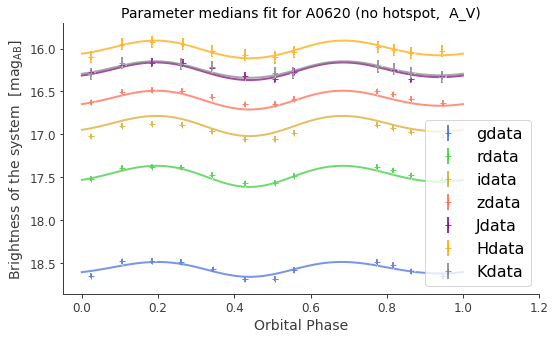

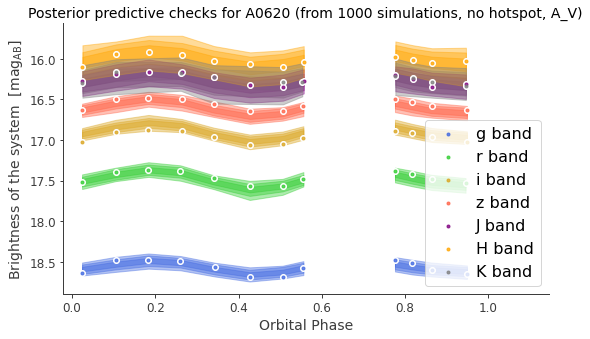

NameError: name 'PPC_per_band_V2' is not defined

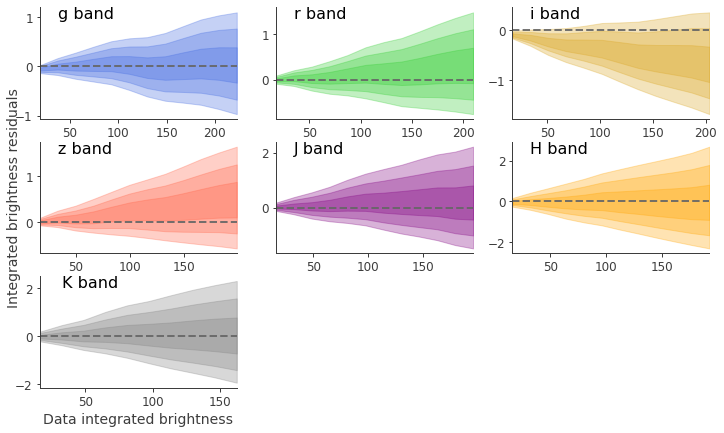

In [30]:
PPC_Creator(my_model, samples, data, identifier='')

## Calculating the primary mass

In [85]:
short_name = 'A06_AV_f_noHS_3comp_4600'
M1res = np.zeros_like(samples[:, 0])
### sadly, scipy optimize has some issue when passing all samples at once; hence the need for a stupid for loop
for j, (inkl, T2) in enumerate(zip(samples[:, 0], samples[:, 1])):
    M1res[j] = M1new(inkl,
                     np.random.default_rng().normal(473.1, 2.0), ### K2 with uncertainty
                     np.random.default_rng().normal(P, 1.e-8), ### orbital period with uncertainty
                     T2
                    )

In [86]:
np.savetxt(f'Folder_M1/AV_{short_name}.txt',
           M1res,
           header='M1 calculated from T2 and i samples'
          )

If you have already calculated the M1 samples, you can load it into memory again and continue without an issue.

In [9]:
M1res = np.loadtxt('/home/yahecker/FluxA06/Folder_M1/AV_A06_AV_f_noHS_3comp.txt', unpack=True)

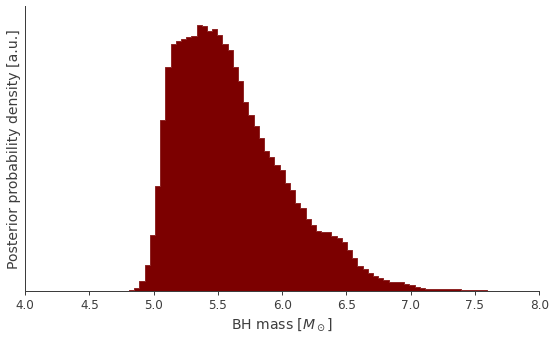

In [5]:
plt.figure(figsize=(8, 5))

min_mass = np.floor(np.min(M1res))
max_mass = np.ceil(np.max(M1res))

bins=np.linspace(min_mass, max_mass, 100)

plt.hist(M1res, bins=bins, density=True, color='#7C0000', ec='#8F2727', histtype='stepfilled')

plt.xlabel(r'BH mass [$M_\odot$]')
plt.xlim([min_mass, max_mass])
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
_, ymax = plt.ylim()
plt.ylim([0, ymax*1.02])
# plt.gca().spines['left'].set_visible(False)
plt.ylabel('Posterior probability density [a.u.]')

plt.tight_layout()

plt.savefig('plots/A06_AV_f_noHS_3comp_BHmass.pdf', format='pdf')

plt.show()

A small overview of my results, as well as severl previously published values.

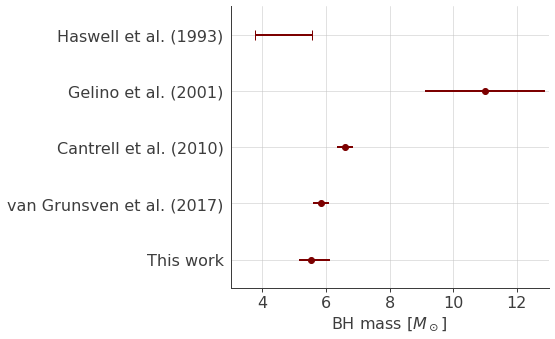

In [27]:
plt.figure(figsize=(8, 5))

min_mass = np.floor(3)
max_mass = np.ceil(13)

masses = np.array([np.median(M1res), 5.84, 6.6, 11.0])
errs = np.array([0.4, 0.24, 0.25, 1.9, 0.6, 0.24, 0.25, 1.9]).reshape((2, 4))

plt.errorbar(masses, np.arange(1, 5), xerr=errs, yerr=None, fmt='o', color='#7C0000')
plt.errorbar((3.76 + 5.55)/2, 5, yerr=None, xerr=(5.55-3.76)/2, marker=None, linestyle=None, color='#7C0000', capsize=5)

names = ['This work', 'van Grunsven et al. (2017)', 'Cantrell et al. (2010)', 'Gelino et al. (2001)', 'Haswell et al. (1993)']

plt.xlabel(r'BH mass [$M_\odot$]', fontsize=16)
plt.xlim([min_mass, max_mass])
plt.tick_params(axis='y', which='both', left=False, right=False)
plt.yticks(ticks=np.arange(1, 6), labels=names, fontsize=16)
plt.xticks(fontsize=16)
_, ymax = plt.ylim()
plt.ylim([0.5, 5.5])

plt.grid()

plt.tight_layout()

plt.savefig('plots/A06_BHmass_comparison.pdf', format='pdf')

plt.show()

In [8]:
np.percentile(M1res, (50, 16, 84))

array([5.54044731, 5.20073162, 6.04966221])

## Donor mass

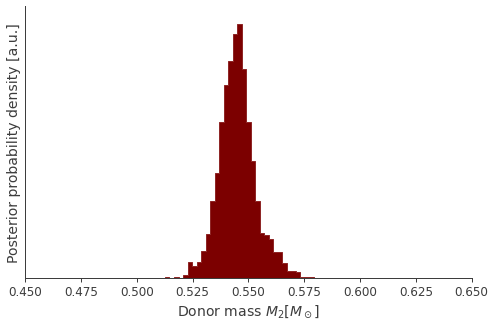

In [10]:
plt.figure()

M2_samples = M2(samples[:, 1])

bins = np.linspace(0.45, 0.65, 100)

plt.hist(M2_samples, bins=bins, density=True, color='#7C0000', ec='#8F2727', histtype='stepfilled')

plt.xlabel(r'Donor mass $M_2 [M_\odot]$')
plt.xlim([bins[0], bins[-1]])
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
_, ymax = plt.ylim()
plt.ylim([0, ymax*1.02])
# plt.gca().spines['left'].set_visible(False)
plt.ylabel('Posterior probability density [a.u.]')


plt.show()

## Mass ratio

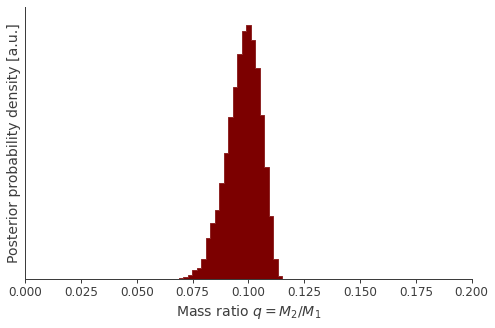

In [12]:
plt.figure()

q = M2_samples / M1res

bins = np.linspace(0, 0.2, 100)

plt.hist(q, bins=bins, density=True, color='#7C0000', ec='#8F2727', histtype='stepfilled')

plt.xlabel(r'Mass ratio $q=M_2/M_1$')
plt.xlim([0, bins[-1]])
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
_, ymax = plt.ylim()
plt.ylim([0, ymax*1.02])
# plt.gca().spines['left'].set_visible(False)
plt.ylabel('Posterior probability density [a.u.]')

plt.savefig('plots/A06_AV_f_noHS_3comp_q.pdf', format='pdf')

plt.show()

In [11]:
np.percentile(q, (50, 16, 84))

array([0.09821985, 0.09000204, 0.1049378 ])

## M1-M2 plot
Of possible interest is also the posterior samples for M1 and M2 and how they may depend on the inclination.

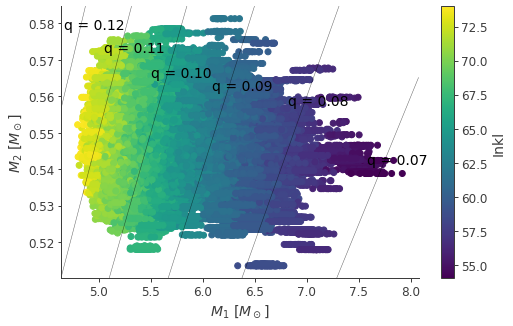

In [22]:
plt.figure()

parameter = 'Inkl'
auswahl = (M2_samples < 2.9)

plt.scatter(M1res, M2_samples, cmap='viridis', c=samples[:, 0])

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

xs = np.linspace(xmin, xmax, 100)
ys = np.linspace(ymin, ymax, 100)

for i, f in enumerate(np.linspace(0.12, 0.06, 7)):
    plt.plot(xs, f*xs, linewidth=0.5, c='k', alpha=0.6)
    crit = np.argmax( xs[f*xs < np.max(M2_samples[auswahl])] ) - i*2
    plt.annotate(f'q = {f:.2f}', ( xs[ crit ] , f*xs[ crit ] ), textcoords='offset points', xytext=(-15, 2))

plt.colorbar(label=parameter)

plt.xlabel(r'$M_1$ [$M_\odot$]')
plt.ylabel(r'$M_2$ [$M_\odot$]')

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

plt.savefig('plots/M1_M2_plot.png', dpi=400)

plt.show()

And, for good measure, also a plot of the inclination over the inferred mass ratio, color coded by M1.

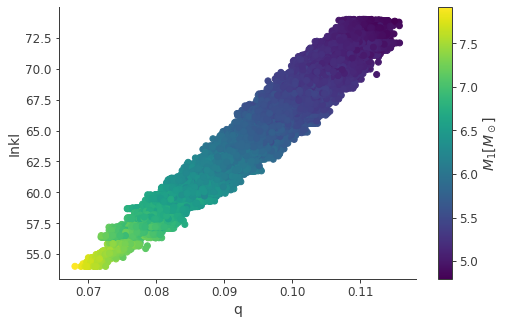

In [24]:
plt.figure()

plt.scatter(q, samples[:, 0], cmap='viridis', c=M1res)

plt.xlabel('q')
plt.ylabel('Inkl')
plt.colorbar(label=r'$M_1 [M_\odot]$')

plt.show()

## Disc solutions
The accretion disc may also be interesting to look at. Starting off with the temperature at the inner edge, we can get a feeling for whether this exceeds hydrogen ionization temperatures or not.

### Inner Temperature

In [49]:
Tinner_samples = np.zeros_like(samples[:, 0])
for j, (T2, TD, f_r, R_in) in enumerate(zip(samples[:, 1], samples[:, 2],  samples[:, 3], samples[:, 4])):
    Tinner_samples[j] = Tinner(
        Tout = TD,
        f_r = f_r,
        R_in = R_in,
        M1 = M1res[j],
        M2 = M2_samples[j]
    )
# np.savetxt('Tinner_MN_90_9.txt', Tinnernew)

CPU times: user 2.65 s, sys: 0 ns, total: 2.65 s
Wall time: 2.64 s


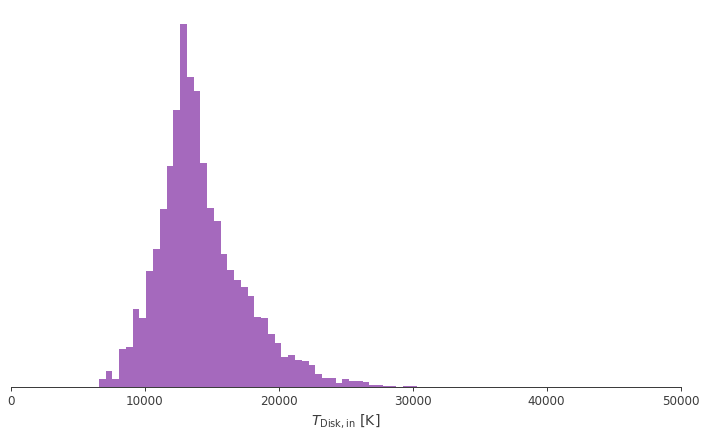

In [50]:
plt.figure()

upper_lim = 10**np.ceil(np.log10(np.max(Tinner_samples)))
lower_lim = 10**np.floor(np.log10(np.min(Tinner_samples)))

bins = np.linspace(0, upper_lim/2, 100)

plt.hist(Tinner_samples, bins=bins, alpha=0.9, density=True)

plt.xlabel(r'$T_\mathrm{Disk,in}$ [K]')
plt.xlim([0, bins[-1]])
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.gca().spines['left'].set_visible(False)

plt.show()

In [51]:
np.percentile(Tinner_samples, (50, 14, 86))

array([13628.698948  , 11136.73014044, 17729.27366497])

### All the radii
Additionally, let's have a look at the physical distances sampled. If all goes well, the disc is somewhat extended and even present at all :D

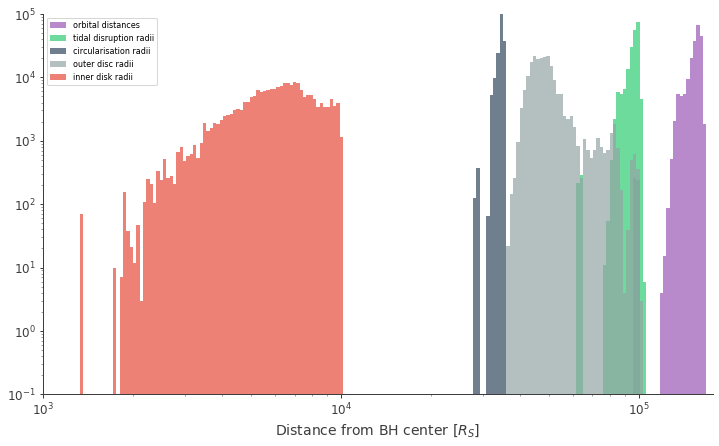

In [52]:
M2_samples = M2(samples[:, 1])

dist = adistance(M2_samples, M1res, P) * Rs   ### [Rs * m / Rs = m]

circ = R_circ(M2_samples, M1res) * dist / R_S(M1res * Ms) ### [a * m/a /m = []]

td = rd_t(M2_samples, M1res) * dist / R_S(M1res * Ms) ### [a * m/a /m = []]

r_disk = circ + samples[:, 3] * (td - circ)

bins = np.geomspace(1000, np.max(dist / R_S(M1res * Ms)), 200)

plt.hist((dist / R_S(M1res * Ms)), bins=bins, alpha=0.7, label='orbital distances')
plt.hist(td, bins=bins, alpha=0.7, label='tidal disruption radii')
plt.hist(circ, bins=bins, alpha=0.7, label='circularisation radii')
plt.hist(r_disk, bins=bins, alpha=0.7, label='outer disc radii')
plt.hist(samples[:, 4], bins=bins, alpha=0.7, label='inner disk radii')

r_out = r_disk / (dist / R_S(M1res * Ms))
r_in = samples[:, 4] / (dist / R_S(M1res * Ms))

plt.xscale('log')
plt.yscale('log')
plt.xlim([1000, np.max(dist / R_S(M1res * Ms))*1.05])
plt.xlabel('Distance from BH center [$R_S$]')

plt.ylim([0.1, 10**5])

plt.legend()

plt.show()

To make it a little easier to look at, only plot the inner and outer disc radii on a linear scale and in relative orbital distances. This is essentially the values that XRbinary would have been provided with.

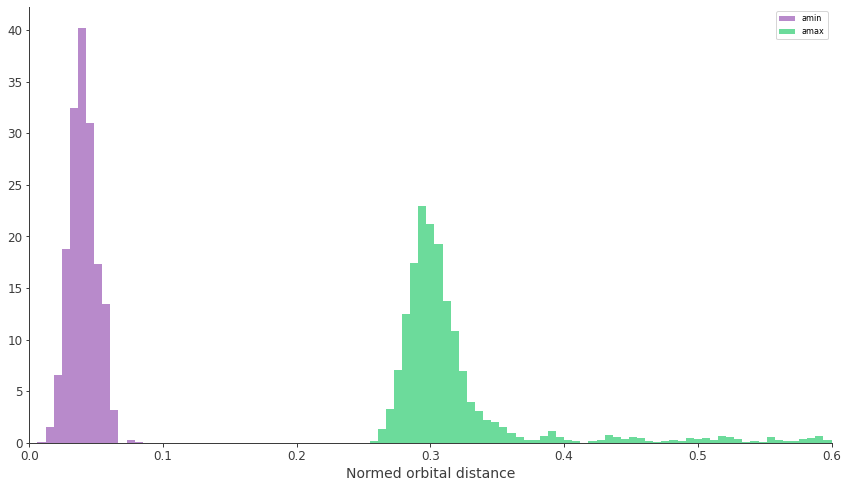

In [53]:
plt.figure()

bins = np.linspace(0, 0.6, 100)

plt.hist(r_in, bins=bins, alpha=0.7, label='amin', density=True)
plt.hist(r_out, bins=bins, alpha=0.7, label='amax', density=True)

plt.xlim([0, np.max(bins)])

plt.xlabel('Normed orbital distance')

plt.legend()

plt.tight_layout()

plt.show()

## Comparison plot for different results
If, like me, you performed different fits with possibly different fixed parameters, priors, samplers or models, you may want to compare them directly. I did this for fixed AV and T2, but this is up to you.

In [11]:
AV_list = np.linspace(0.3, 0.9, 4)
# T2_list = np.array([3800, 3900, 4000, 4100, 4200, 4600])

path = 'Fitting_Results/A06_f_noHS_3comp_%02d.fits'
# path = 'Fitting_Results/A06_f_noHS_3comp_Tsec_%d.fits'

### for AV fix fits
sample_size = 400*500

### for T2 fix fits
# sample_size = 441*500

results = {'Inkl':np.zeros((len(AV_list), sample_size)),
           'T_Sec':np.zeros((len(AV_list), sample_size)),
           'M_BH':np.zeros((len(AV_list), sample_size))
          }

# results = {'Inkl':np.zeros((len(T2_list), sample_size)),
#            'A_V':np.zeros((len(T2_list), sample_size)),
#            'M_BH':np.zeros((len(T2_list), sample_size))
#           }


for i, Av in enumerate(AV_list):
# for i, T2 in enumerate(T2_list):
    
    with fits.open(path%(10*Av)) as head:
    # with fits.open(path%T2) as head:
        dat = head[1].data
        # for j, key in enumerate(results.keys()):
        for j, key in zip([0, 1], results.keys()):   ### for fits with constant AV
        # for j, key in zip([0, 4], results.keys()):   ### for fits with constant T2
            ### save the samples into the dict
            results[key][i] = dat[j][-1]
    results['M_BH'][i] = np.loadtxt(f'Folder_M1/AV_A06_AV_f_noHS_3comp_{int(10*Av):02d}.txt', unpack=True)
    # results['M_BH'][i] = np.loadtxt(f'Folder_M1/AV_A06_AV_f_noHS_3comp_{T2}.txt', unpack=True)
    

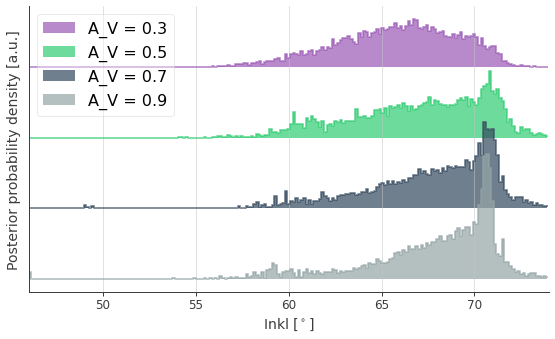

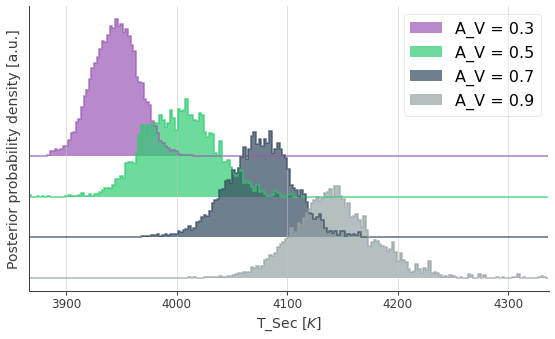

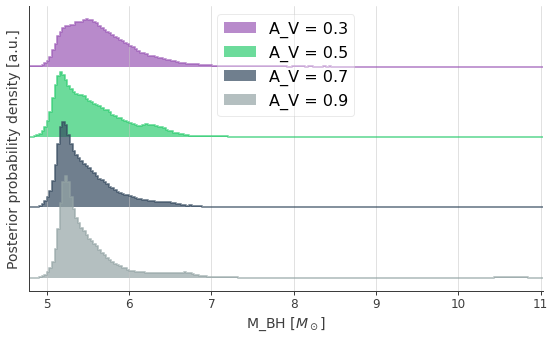

In [12]:
units = [r'$^\circ$', r'$K$', r'$M_\odot$']

# units = [r'$^\circ$', r'$\mathrm{mag_{AB}}$', r'$M_\odot$']

bin_number = 200
alpha = 0.6
alpha_fill = 0.7

shift_factor = -1

for j, (key, samples) in enumerate(results.items()):

    plt.figure()
    
    loc_min, loc_max = np.min(samples), np.max(samples)
    
    bins = np.linspace(loc_min, loc_max, bin_number)
    
    scale = np.max([np.histogram(samples, bins=bins, density=True)[0]])
    
    for ev, AV in enumerate(AV_list):   # go through all models with fixed AV
    # for ev, T2 in enumerate(T2_list):   # go through all models with fixed T2
            
        vals, edges = np.histogram(samples[ev], bins=bins, density=True)    # create histogrammed values of the variates
        centers = (edges[1:] + edges[:-1]) / 2.   # central values of the histogrammed values
                
        # shift each iteration upwards by some amount for visual presentation purposes
        lower = scale*ev/shift_factor
        upper = vals + lower
        
        plt.plot(centers, upper, drawstyle='steps-mid', alpha=alpha)
        
        plt.fill_between(centers, upper, lower, alpha=alpha_fill, step='mid', label=f'A_V = {AV:.1f}')
        # plt.fill_between(centers, upper, lower, alpha=alpha_fill, step='mid', label=f'T_Sec = {T2} K')
    
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticks([])
    
    plt.xlabel(f'{key} [{units[j]}]')
    plt.xlim([bins[0], bins[-1]])
    plt.grid()
    plt.legend(framealpha=0.4)
    plt.ylabel('Posterior probability density [a.u.]')
    plt.tight_layout()
    plt.savefig(f'plots/A06_comparison_AV_{key}.pdf', format='pdf')
    # plt.savefig(f'plots/A06_comparison_T2_{key}.pdf', format='pdf')

plt.show()